PIPR with STLAB
===============

The post-illumination pupil response (PIPR) is the sustained constriction of the pupil following exposure to short wavelength blue light. In addition to the classical rod and cone photoreceptors, the retina also contains *intrinsically photosensetive retinal ganglion cells (ipRGCs)* expressing a photopigment called the photopigment melanopsin, which is maximally sensetive to short wavelength (blue) light. The ipRGCs project to the suprachiasmatic neucleus and the olivary pretectal nucleus and are involved in 'non-visual' functions, such as circadian photoentrainment and pupil control. The post illumination pupil response is usually characterised by comparing pupil responses to short- and long-wavelength lights. It is assumed to be a unique non-invasive signature of melanopsin processing in the human retina.

Preparing stimuli
-----------------

For this protocol, the goal is to create two light pulses that are matched for overall radiance but differentially excite melanopsin. As an optimum protocol for exploring melanopsin function, [Park et al. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3175993/) recommend comparing the pupil responses to high intensity (~400 lx) 1 s pulses of short and long wavelength light presented in darkness following a period of dark adaptation. So we can start by creating a blue light stimulus that is safe and which will produce the desired effects. To do this, we can create a `CalibrationContext(...)` from our spectrometer data we acquired.

Text(0, 0.5, 'W/m2/nm')

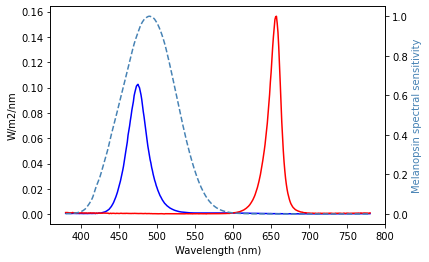

In [52]:
import sys
sys.path.insert(0, '../')
from pyplr.stlab import CalibrationContext
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

cc = CalibrationContext('../data/corrected_oo_spectra.csv', binwidth=1)

blue_intensity = (cc.lux.loc[3].sub(400)
                               .abs()
                               .idxmin()
                               .values[0])
red_intensity = cc.match(match_led=3, 
                         match_led_intensity=blue_intensity, 
                         target_led=9, 
                         match_type='irrad')[1]


fig, ax = plt.subplots()
sss = get_CIES026(asdf=True, binwidth=1)
ax.plot(cc.lkp.loc[(3,blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(9,red_intensity)], c='red')
    
ax2 = ax.twinx()
ax2.plot(sss["Mel"], ls='dashed', c='steelblue')
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

All that remains is to turn them into video files for the STLAB:

In [57]:
from pyplr import stlab
blue = [0, 0, 0, blue_intensity, 0, 0, 0, 0, 0, 0]
red  = [0, 0, 0, 0, 0, 0, 0, 0, 0, red_intensity]
stlab.pulse_protocol(pulse_spec=blue,
                     pulse_duration=1000, 
                     fname='1s_blue',
                     metadata={'color':'blue'})
stlab.pulse_protocol(pulse_spec=red, 
                     pulse_duration=1000, 
                     fname='1s_red',
                     metadata={'color':'red'})

"1s_blue.dsf" saved in the current working directory.
"1s_red.dsf" saved in the current working directory.


Running the experiment
----------------------

After a period of dark adaptation, we can run the experiment.

In [ ]:
# connect to Pupil Core
p = PupilCore()

# connect to stlab
d = SpectraTuneLab(username='admin', identity=1, password='83e47941d9e930f6')

# start recording
p.command('R {}'.format(os.getcwd()))

# wait for the 3d model to build up enough samples
sleep(10.)  

# loop over the list of stims
for stim in stims:
    
    # load video file and create trigger with metadata
    vf = d.load_video_file(stim)
    trigger = {**new_trigger('LIGHT_ON'), **vf['metadata']}
    
    # baseline
    sleep(10.)
    
    # set up and start the LightStamper thread 
    lst_future = pupil.light_stamper(p, threshold=15, annotation=annotation, timeout=6)
    
    # wait 200 ms
    sleep(.2)
    
    # play the video file
    d.play_video_file()
    sleep(60.)  

# finish recording
sleep(5.)   
p.command('r')